<a href="https://colab.research.google.com/github/TeachingTextMining/TextClassification/blob/main/04-SA-Transformers-Training-Custom/04-TextClassification-with-Transformers-FeatureComposition-Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de textos utilizando Transformers. Combinación de características

La clasificación de textos consiste en, dado un texto, asignarle una entre varias categorías. Algunos ejemplos de esta tarea son:

- dado un tweet, categorizar su connotación como positiva, negativa o neutra.
- dado un post de Facebook, clasificarlo como portador de un lenguaje ofensivo o no.  

En la figura se muestra una arquitectura que permite combinar diferentes tipos de características en la construcción de un clasificador para resolver esta tarea. 

La idea general es contar con varios extractores de rasgos para representar el texto, realizar una selección de características y finalmente, entrenar un clasificador con las variables seleccionadas.

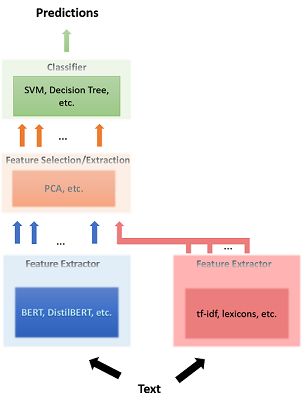

En la actividad exploraremos cómo utilizar la librería [Transformers](https://huggingface.co/transformers/) para construir este modelo y entrenarlo para clasificar reviews de [IMDB](https://www.imdb.com/) sobre películas en las categorías \[$positive$, $negative$\]. 

Como clasificador se utilizará una red neuronal tipo Perceptrón Multicapas, y como características adicionales la representación del texto utilizando [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

Puede encontrar más información sobre este problema en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) y en [Large Movie Review Datase](http://ai.stanford.edu/~amaas/data/sentiment/). También consultar el tutorial sobre [Fine-tunning de modelos](ttps://huggingface.co/docs/transformers/training) en la web del proyecto Transformers.

**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.

**Después de esta actividad nos habremos familiarizado con:**

- la arquitectura de un modelo para clasificar textos que combina diferentes rasgos para representar el texto, por ejemplo, Transformers y otras características propias del dominio.

- el re-entrenamiento de modelos para la clasificación de secuencias.

- aspectos importantes a tener en cuenta como el formato de los datos, y la especificación de las entradas en el modelo.

**Requerimientos**
- python 3.6.12 - 3.8
- tensorflow==2.3.0
- transformers==4.2.1
- pandas==1.1.5
- plotly==4.13.0
- tqdm==4.56.0
- scikit-learn==0.24.0

**Note que:** 
- el propósito principal de la actividad es ilustrar cómo utilizar la librería Transformers para construir modelos que combinen diferentes tipos de características. No necesariamente esta arquitectura conducirá a los mejores resultados.

- en dependencia del entorno de ejecución, puede ser necesario instalar manualmente alguno de estos paquetes.



<a name="sec:setup"></a>
### Instalación de librerías e importación de dependencias.

Para comenzar, es preciso instalar las dependencias, realizar los imports necesarios y definir algunas funciones auxiliares.

Ejecute las siguientes casillas prestando atención a las instrucciones adicionales en los comentarios.

In [23]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow, etc. que en este caso se encontrarían ya instaladas
%%capture
%pip install transformers==4.26.0 tensorflow==2.9.0 pandas==1.3.5 plotly==5.5.0 scikit-learn==1.0.0
%pip install emoji
%pip install num2words
#print('Done!')

UsageError: Line magic function `%%capture` not found.


In [24]:
# reset environment
%reset -f

#Libraries to establish file paths
import os

#Libraries to load data and perform basic preprocessing
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Libraries to evaluate the models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

#Libraries to build graphics and perform exploratory data analysis
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm
import numpy as np
import random

#Libraries to save the model
import pickle
import tensorflow as tf
from tensorflow.keras import layers

#Libraries to visualize the model
from IPython.display import display, HTML

#Libraries for classification algorithms, tokenizers, etc.
import nltk
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertMainLayer
from nltk.tokenize import word_tokenize
import string as st
import re
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import sentiwordnet as swn

import emoji
from num2words import num2words

nltk.download('all')
nltk.download('stopwords')


print('Done!')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    | 

Done!


[nltk_data]    |   Package wordnet2021 is already up-to-date!
[nltk_data]    | Downloading package wordnet2022 to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wordnet2022 is already up-to-date!
[nltk_data]    | Downloading package wordnet31 to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all
[nltk_data] 

In [25]:
tf.random.set_seed = 0
np.random.seed(0)
random.seed = 0

## DEFINICIÓN DE EMOTICONOS

In [26]:
EMOTICONS_EMO = {
    u":‑)":"Cara feliz o smiley",
    u":-))":"Cara muy feliz o sonriente",
    u":-)))":"Cara muy muy feliz o sonriente",
    u":)":"Cara feliz o smiley",
    u":))":"Cara muy feliz o sonriente",
    u":)))":"Cara muy muy feliz o sonriente",
    u":-]":"Cara feliz o smiley",
    u":]":"Cara feliz o smiley",
    u":-3":"Cara feliz Smiley",
    u":3":"Cara feliz Smiley",
    u":->":"Cara feliz Smiley",
    u":>":"Cara feliz Smiley",
    u"8-)":"Cara feliz Smiley",
    u":o)":"Cara feliz Smiley",
    u":-}":"Cara feliz Smiley",
    u":}":"Cara feliz Smiley",
    u":-)":"Cara feliz Smiley",
    u":c)":"Cara feliz Smiley",
    u":^)":"Cara feliz Smiley",
    u"=]":"Cara feliz Smiley",
    u"=)":"Cara feliz Smiley",
    u":‑D":"Riendo, gran sonrisa o risa con gafas",
    u":D":"Riendo, gran sonrisa o risa con gafas",
    u"8‑D":"Riendo, gran sonrisa o risa con gafas",
    u"8D":"Riendo, gran sonrisa o risa con gafas",
    u"X‑D":"Riendo, gran sonrisa o risa con gafas",
    u"XD":"Riendo, gran sonrisa o risa con gafas",
    u"=D":"Riendo, gran sonrisa o risa con gafas",
    u"=3":"Riendo, gran sonrisa o risa con gafas",
    u"B^D":"Riendo, gran sonrisa o risa con gafas",
    u":-))":"Muy feliz",
    u":-(":"Fruncir el ceño, triste, enojado o puchero",
    u":‑(":"Fruncir el ceño, triste, enojado o puchero",
    u":(":"Fruncir el ceño, triste, enojado o puchero",
    u":‑c":"Fruncir el ceño, triste, enojado o puchero",
    u":c":"Fruncir el ceño, triste, enojado o puchero",
    u":‑<":"Fruncir el ceño, triste, enojado o puchero",
    u":<":"Fruncir el ceño, triste, enojado o puchero",
    u":‑[":"Fruncir el ceño, triste, enojado o puchero",
    u":[":"Fruncir el ceño, triste, enojado o puchero",
    u":-||":"Fruncir el ceño, triste, enojado o puchero",
    u">:[":"Fruncir el ceño, triste, enojado o puchero",
    u":{":"Fruncir el ceño, triste, enojado o puchero",
    u":@":"Fruncir el ceño, triste, enojado o puchero",
    u">:(":"Fruncir el ceño, triste, enojado o puchero",
    u":'‑(":"Llanto",
    u":'(":"Llanto",
    u":'‑)":"Lagrimas de felicidad",
    u":')":"Lagrimas de felicidad",
    u"D‑':":"Horror",
    u"D:<":"Asco",
    u"D:":"Tristeza",
    u"D8":"Gran consternación",
    u"D;":"Gran consternación",
    u"D=":"Gran consternación",
    u"DX":"Gran consternación",
    u":‑O":"Sorpresa",
    u":O":"Sorpresa",
    u":‑o":"Sorpresa",
    u":o":"Sorpresa",
    u":-0":"Choque",
    u"8‑0":"Bostezo",
    u">:O":"Bostezo",
    u":-*":"Beso",
    u":*":"Beso",
    u":X":"Beso",
    u";‑)":"Guiño o sonríe",
    u";)":"Guiño o sonríe",
    u"*-)":"Guiño o sonríe",
    u"*)":"Guiño o sonríe",
    u";‑]":"Guiño o sonríe",
    u";]":"Guiño o sonríe",
    u";^)":"Guiño o sonríe",
    u":‑,":"Guiño o sonríe",
    u";D":"Guiño o sonríe",
    u":‑P":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u":P":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u"X‑P":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u"XP":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u":‑Þ":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u":Þ":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u":b":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u"d:":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u"=p":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u">:P":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u":‑/":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u":/":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u":-[.]":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u">:[(\)]":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u">:/":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u":[(\)]":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u"=/":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u"=[(\)]":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u":L":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u"=L":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u":S":"Escéptico, molesto, indeciso, incómodo o vacilante",
    u":‑|":"Cara seria",
    u":|":"Cara seria",
    u":$":"Avergonzado o sonrojo",
    u":‑x":"Labios sellados o con aparatos ortopédicos o lengua",
    u":x":"Labios sellados o con aparatos ortopédicos o lengua",
    u":‑#":"Labios sellados o con aparatos ortopédicos o lengua",
    u":#":"Labios sellados o con aparatos ortopédicos o lengua",
    u":‑&":"Labios sellados o con aparatos ortopédicos o lengua",
    u":&":"Labios sellados o con aparatos ortopédicos o lengua",
    u"O:‑)":"Ángel, santo o inocente",
    u"O:)":"Ángel, santo o inocente",
    u"0:‑3":"Ángel, santo o inocente",
    u"0:3":"Ángel, santo o inocente",
    u"0:‑)":"Ángel, santo o inocente",
    u"0:)":"Ángel, santo o inocente",
    u":‑b":"Lengua sobresaliendo, descarada, juguetona o soplando una frambuesa",
    u"0;^)":"Ángel, santo o inocente",
    u">:‑)":"Malvado o diabólico",
    u">:)":"Malvado o diabólico",
    u"}:‑)":"Malvado o diabólico",
    u"}:)":"Malvado o diabólico",
    u"3:‑)":"Malvado o diabólico",
    u"3:)":"Malvado o diabólico",
    u">;)":"Malvado o diabólico",
    u"|;‑)":"Fresco",
    u"|‑O":"Aburrido",
    u":‑J":"Irónico",
    u"#‑)":"Fiesta toda la noche",
    u"%‑)":"Borracho o confundido",
    u"%)":"Borracho o confundido",
    u":-###..":"Estar enferma",
    u":###..":"Estar enferma",
    u"<:‑|":"Vertedero",
    u"(>_<)":"Preocupado",
    u"(>_<)>":"Preocupado",
    u"(';')":"Bebé",
    u"(^^>``":"Nervioso o avergonzado o problemático o tímido o gota de sudor",
    u"(^_^;)":"Nervioso o avergonzado o problemático o tímido o gota de sudor",
    u"(-_-;)":"Nervioso o avergonzado o problemático o tímido o gota de sudor",
    u"(~_~;) (・.・;)":"Nervioso o avergonzado o problemático o tímido o gota de sudor",
    u"(-_-)zzz":"Durmiendo",
    u"(^_-)":"Guiño",
    u"((+_+))":"Confundido",
    u"(+o+)":"Confundido",
    u"(o|o)":"Ultramán",
    u"^_^":"Alegre",
    u"(^_^)/":"Alegre",
    u"(^O^)／":"Alegre",
    u"(^o^)／":"Alegre",
    u"(__)":"Kowtow como signo de respeto, o dogeza para disculpas",
    u"_(._.)_":"Kowtow como signo de respeto, o dogeza para disculpas",
    u"<(_ _)>":"Kowtow como signo de respeto, o dogeza para disculpas",
    u"<m(__)m>":"Kowtow como signo de respeto, o dogeza para disculpas",
    u"m(__)m":"Kowtow como signo de respeto, o dogeza para disculpas",
    u"m(_ _)m":"Kowtow como signo de respeto, o dogeza para disculpas",
    u"('_')":"Triste o llorando",
    u"(/_;)":"Triste o llorando",
    u"(T_T) (;_;)":"Triste o llorando",
    u"(;_;":"Triste por llorar",
    u"(;_:)":"Triste o llorando",
    u"(;O;)":"Triste o llorando",
    u"(:_;)":"Triste o llorando",
    u"(ToT)":"Triste o llorando",
    u";_;":"Triste o llorando",
    u";-;":"Triste o llorando",
    u";n;":"Triste o llorando",
    u";;":"Triste o llorando",
    u"Q.Q":"Triste o llorando",
    u"T.T":"Triste o llorando",
    u"QQ":"Triste o llorando",
    u"Q_Q":"Triste o llorando",
    u"(-.-)":"Lástima",
    u"(-_-)":"Lástima",
    u"(一一)":"Lástima",
    u"(；一_一)":"Lástima",
    u"(=_=)":"Cansado",
    u"(=^·^=)":"gato",
    u"(=^··^=)":"gato",
    u"=_^= ":"gato",
    u"(..)":"Mirando abajo",
    u"(._.)":"Mirando abajo",
    u"^m^":"Reír con la boca cubierta de mano",
    u"(・・?":"Confusión",
    u"(?_?)":"Confusión",
    u">^_^<":"Risa normal",
    u"<^!^>":"Risa normal",
    u"^/^":"Risa normal",
    u"（*^_^*）" :"Risa normal",
    u"(^<^) (^.^)":"Risa normal",
    u"(^^)":"Risa normal",
    u"(^.^)":"Risa normal",
    u"(^_^.)":"Risa normal",
    u"(^_^)":"Risa normal",
    u"(^^)":"Risa normal",
    u"(^J^)":"Risa normal",
    u"(*^.^*)":"Risa normal",
    u"(^—^）":"Risa normal",
    u"(#^.^#)":"Risa normal",
    u"（^—^）":"Ondulación",
    u"(;_;)/~~~":"Ondulación",
    u"(^.^)/~~~":"Ondulación",
    u"(-_-)/~~~ ($··)/~~~":"Ondulación",
    u"(T_T)/~~~":"Ondulación",
    u"(ToT)/~~~":"Ondulación",
    u"(*^0^*)":"Entusiasmado",
    u"(*_*)":"Asombrado",
    u"(*_*;":"Asombrado",
    u"(+_+) (@_@)":"Asombrado",
    u"(*^^)v":"Riendo, alegre",
    u"(^_^)v":"Riendo, alegre",
    u"((d[-_-]b))":"Auriculares, escuchando música",
    u'(-"-)':"Preocupado",
    u"(ーー;)":"Preocupado",
    u"(^0_0^)":"Los anteojos",
    u"(＾ｖ＾)":"Feliz",
    u"(＾ｕ＾)":"Feliz",
    u"(^)o(^)":"Feliz",
    u"(^O^)":"Feliz",
    u"(^o^)":"Feliz",
    u")^o^(":"Feliz",
    u":O o_O":"Sorprendido",
    u"o_0":"Sorprendido",
    u"o.O":"Asustado",
    u"(o.o)":"Sorprendido",
    u"oO":"Sorprendido",
    u"(*￣m￣)":"Insatisfecho",
    u"(‘A`)":"Desausado o desinflado"
}

In [27]:
TEXT_COL      = 'tweet'
CLASS_COL_ST1 = 'sentiment'
CLASS_COL_ST2 = ['Theft', 'Homicide', 'Kidnapping', 'Accident', 'None of the above']

STOP_WORDS_SP = set(stopwords.words('spanish'))

# Declaramos algunas variables globales
N_JOBS = 6 # Número de núclos a implementar por gridsearch para el hyper parámeter tuning
CV = 5 # Número de interaciones para hacer cross validation.

In [28]:
# función auxiliar utilizada por CountVectorizer para procesar las frases
def spanish_stemmer(sentence):
    stemmer = SpanishStemmer()
    analyzer = CountVectorizer(binary=False, analyzer='word', stop_words=STOP_WORDS_SP,
                               ngram_range=(1, 1)).build_analyzer()
    return (stemmer.stem(word) for word in analyzer(sentence))



def get_word_scores(cfg, data):
  pos_scores = []
  neg_scores = []
  obj_scores = []
  ### Iteramos sobre cada una de las entradas del dataset
  for i in range(len(data)):
    ### Separamos por palabras
    words = data[i].split(' ')
    words = list(filter(None, words))
    pos_entry = []
    neg_entry = []
    obj_entry = []
    ### Iteramos el número de veces que indica cfg['max_length']
    for j in range(cfg['max_length']):
      ### Si hay una palabra, añadimos la media de sus scores, sino un 0
      if j < len(words):
        sentiments = list(swn.senti_synsets(words[j]))
        if len(sentiments) == 0:
          pos_entry.append(0)
          neg_entry.append(0)
          obj_entry.append(0)
        else:
          ### Añadimos la media de todos los casos devueltos por SentiWordNet 
          mean_pos = sum([x.pos_score() for x in sentiments]) / len(sentiments)
          mean_neg = sum([x.neg_score() for x in sentiments]) / len(sentiments)
          mean_obj = sum([x.obj_score() for x in sentiments]) / len(sentiments)
          pos_entry.append(mean_pos)
          neg_entry.append(mean_neg)
          obj_entry.append(mean_obj)
      else:
        pos_entry.append(0)
        neg_entry.append(0)
        obj_entry.append(0)
    ### Guardamos los scores
    pos_scores.append(pos_entry)
    neg_scores.append(neg_entry)
    obj_scores.append(obj_entry)
  pos_scores = np.array(pos_scores)
  neg_scores = np.array(neg_scores)
  obj_scores = np.array(obj_scores)

  print(pos_scores)
  print()
  print(neg_scores)
  print()
  print(obj_scores)
  print()
  return pos_scores, neg_scores, obj_scores

# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs(cfg, data):
    ### Añadiendo la media de los diferentes scores para cada palabra que compone la entrada
    pos_scores, neg_scores, obj_scores = get_word_scores(cfg, data)

    # obtener ids y máscaras para el conjunto de entrenamiento
    # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato, 
    encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])

    # obtener representación tf-idf de cada instancia
    tfidf = cfg['vectorizer'].transform(data)
    tfidf_t = tf.convert_to_tensor(tfidf.toarray(), dtype=tf.float32)

    # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
    # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf') 
    # son utilizados como llaves en los diccionarios que representan las entradas al modelo
    inputs = {'input_ids': encodings['input_ids'],
              'attention_mask': encodings['attention_mask'],
              'tfidf': tfidf_t,
              'pos_scores': pos_scores,
              'neg_scores': neg_scores,
              'obj_scores': obj_scores,
            }

    return inputs


# función auxiliar para realizar predicciones con el modelo
def predict_model(model, cfg, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs(cfg, data)
  scores = model.predict(inputs)
  
  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title = f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')
    
    fig_roc.show()

print('Done!')

Done!


### Carga de datos y análisis exploratorio

El primer paso consiste en obtener los datos relacionados con nuestra tarea dejándolos en el formato adecuado.  Existen diferentes opciones, entre estas:

- montar nuestra partición de Google Drive y leer un fichero desde esta.

- leer los datos desde un fichero en una carpeta local.

- leer los datos directamente de un URL.

En este caso, se encuentran en un fichero separado por comas con la siguiente estructura:

| Phrase | Sentiment| 
| ------ | ------ |
| This movie is really not all that bad...    | positive |


Ejecute la siguiente casilla para leer los datos.



In [29]:
# descomente la siguiente línea para leer datos desde un URL
tweets_train_path = 'https://github.com/carlossuazo/davincis-iberlef-2023/raw/main/data/training_data/train_data.csv'
labels_train_path = 'https://github.com/carlossuazo/davincis-iberlef-2023/raw/main/data/training_data/train_labels_subtask_1.csv'

tweets_test_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/training_data/trial_data/trial_data.csv'
labels_test_path = 'https://raw.githubusercontent.com/carlossuazo/davincis-iberlef-2023/main/data/training_data/trial_data/trial_labels_subtask_1.csv'

# Dataset de entrenamiento
df_train            = pd.read_csv(tweets_train_path, header=None, names = [TEXT_COL])
df_train_labels_st1 = pd.read_csv(labels_train_path, header=None, names = [CLASS_COL_ST1])

# Dataset de test
df_test            = pd.read_csv(tweets_test_path, header=None, names = [TEXT_COL])
df_test_labels_st1 = pd.read_csv(labels_test_path, header=None, names = [CLASS_COL_ST1])

df_train = pd.concat([df_train, df_train_labels_st1], axis = 1)
df_test = pd.concat([df_test, df_test_labels_st1], axis = 1)
display(df_train)
display(df_test)

,tweet,sentiment
0,#Ahora | Reportan accidente de tránsito en el ...,1
1,#PrecauciónVial en #CDMX se registra cierre pa...,0
2,#traficogt 🚨🚨👉 https://t.co/1Y9A5BmbKU 3. Se...,0
3,#HoyMismo #Internacionales | El Gobierno de J...,0
4,"Casos como el accidente en Villa Lorena, en el...",0
...,...,...
3357,"Bomberos atendieron accidente vehicular, vía h...",1
3358,El @bellasartesinba y @literaturainba recuerda...,0
3359,Recientemente lo dejaron libre bajo fianza y a...,1
3360,Accidente en Calle 127 &gt; Oriente #traficobo...,0


,tweet,sentiment
0,Accidente en el Vallado frente al polideportiv...,1
1,Vitor Belfort abruma a Evander Holyfield en la...,0
2,"En México, las estadísticas de violencia homic...",0
3,"Como Jorge Armando Ayala Guarín de 25 años, f...",1
4,Quebrar un vidrio ///// Quebrar el país a plom...,0
5,"#EsNoticia 📌 En aparente estado de embriaguez,...",1
6,@DiloneMarrero Por último ponga la queja en CN...,0
7,174 aniversario de la Gesta Heroica de los Niñ...,0
8,SigAlert en Lake Elsinore. En la I-15 norte ce...,0
9,LO ÚLTIMO Al menos dos personas resultaron her...,1


Una vez leídos los datos, ejecute la siguiente casilla para construir una gráfica que muestra la distribución de clases en el corpus.


In [30]:
# obtener algunas estadísticas sobre los datos
categories = sorted(df_train[CLASS_COL_ST1].unique(), reverse=False)
hist= Counter(df_train[CLASS_COL_ST1]) 
print(f'Total de instancias -> {df_train.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(df_train[CLASS_COL_ST1]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {df_train[TEXT_COL][0]}')
print(f'Categoría del comentario -> {df_train[CLASS_COL_ST1][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Total de instancias -> 3362
Distribución de clases:
    0: 0.535
    1: 0.465
Categorías -> [0, 1]
Comentario de ejemplo -> #Ahora | Reportan accidente de tránsito en el ingreso al municipio de Salcajá. Dos vehículos tipo picop involucrados en el percances.  Precaución al conducir por el sector.  Ampliaremos la información.   📸Esvin Mazariegos  #Stereo100Noticias  https://t.co/uOs4r5ylwN
Categoría del comentario -> 1


Done!


# Limpieza de texto y pasos de preprocesamiento

In [31]:
df_train['emo_to_words'] = df_train[TEXT_COL].apply(lambda x: emoji.demojize(x, language='es', delimiters=(' ', ' ')))

# remove hashtags
def hashtags(text):
  hash = re.sub(r"#(\w+)", ' ', text)
  return hash

df_train['remove_hash'] = df_train['emo_to_words'].apply(lambda x: hashtags(x))

def remove_users(tweet):
  '''Takes a string and removes retweet and @user information'''
  tweet = re.sub('@[^\s]+', ' ', tweet) 
  # remove tweeted at
  return tweet

df_train['remove_user'] = df_train['remove_hash'].apply(lambda x: remove_users(x))

def remove_underscore(text):
	return text.replace('_', ' ')

df_train['remove_underscore'] = df_train['remove_user'].apply(lambda x: remove_underscore(x))

def remove_urls(text):
	"""
	Return :- String without URLs
	input :- String
	Output :- String
	"""
	url_pattern = r'http://\S+|https://\S+'
	without_urls = re.sub(pattern=url_pattern, repl=' ', string=text)
	return without_urls

df_train['url_cleaned'] = df_train['remove_underscore'].apply(lambda x: remove_urls(x))

def emoticons_words(text):
	for emot in EMOTICONS_EMO:
		text = text.replace(emot, EMOTICONS_EMO[emot])
	return text

df_train['emoticons_words'] = df_train['url_cleaned'].apply(lambda x: emoticons_words(x))

def remove_html_tags(text):
	"""
	Return :- String without Html tags
	input :- String
	Output :- String
	"""
	html_pattern = r'<.*?>'
	without_html = re.sub(pattern=html_pattern, repl=' ', string=text)
	return without_html

df_train['remove_html_tags'] = df_train['emoticons_words'].apply(lambda x: remove_html_tags(x))

# Remove all punctuations from the text
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))
    
df_train['removed_punc'] = df_train['remove_html_tags'].apply(lambda x: remove_punct(x))

# function to convert numbers to words
# def num_to_words(text):
# 	"""
# 	Return :- text which have all numbers or integers in the form of words
# 	Input :- string
# 	Output :- string
# 	"""
# 	# splitting text into words with space
# 	after_spliting = text.split()

# 	for index in range(len(after_spliting)):
# 		if after_spliting[index].isdigit():
# 			after_spliting[index] = num2words(after_spliting[index], lang='es')

#     # joining list into string with space
# 	numbers_to_words = ' '.join(after_spliting)
# 	return numbers_to_words
def remove_numbers(text):
	"""
	Return :- String without numbers
	input :- String
	Output :- String
	"""
	number_pattern = r'\d+'
	without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
	return without_number

df_train['num_to_words'] = df_train['removed_punc'].apply(lambda x: remove_numbers(x))

# Tokenize the text
df_train['tokens'] = df_train['num_to_words'].apply(lambda msg : word_tokenize(msg.lower()))

# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

df_train['larger_tokens'] = df_train['tokens'].apply(lambda x : remove_small_words(x))

''' Remove stopwords. Here, NLTK corpus list is used for a match. However, a customized user-defined 
    list could be created and used to limit the matches in input text. 
'''
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('spanish')]

df_train['clean_tokens'] = df_train['larger_tokens'].apply(lambda x : remove_stopwords(x))

# Apply stemming to get root words 
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

df_train['stem_words'] = df_train['clean_tokens'].apply(lambda wrd: stemming(wrd))

# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

df_train['lemma_words'] = df_train['clean_tokens'].apply(lambda x : lemmatize(x))

# Annotate each word with its part-of-speech tag
def get_pos_tag(tokenized_sentence):
    return nltk.pos_tag(tokenized_sentence)

df_train['pos_tag'] = df_train['tokens'].apply(lambda x : get_pos_tag(x))

# Extract the root words from the sentence
def get_root_word(tokenized_sentence):
    for word, pos in nltk.pos_tag(tokenized_sentence):
        if pos.startswith('NN'):
            return word

df_train['root_word'] = df_train['lemma_words'].apply(lambda x : get_root_word(x))

df_train['root_word'] 

# Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

df_train[TEXT_COL] = df_train['lemma_words'].apply(lambda x : return_sentences(x))


df = pd.DataFrame()
df[TEXT_COL] = df_train[TEXT_COL]
df[CLASS_COL_ST1] = df_train[CLASS_COL_ST1]
df_train = df.copy()
# save the dataframe as csv file
df_train.to_csv('train_cleaned.csv', index=False)

Finalmente, ejecute la siguiente casilla para crear los conjuntos de entrenamiento y validación que se utilizarán para entrenar y validar los modelos.

In [32]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0  # fijar random_state para reproducibilidad
train, val = train_test_split(df_train, test_size=.1, stratify=df_train[CLASS_COL_ST1], random_state=seed)
print(f'Instancias de entrenamiento -> {train.shape[0]}')
print(f'Instancias de entrenamiento -> {val.shape[0]}')
print(train)
print(val)
print('Done!')

Instancias de entrenamiento -> 3025
Instancias de entrenamiento -> 337
                                                  tweet  sentiment
2165  atienden accidente vehicular colisión multiple...          1
4     casos accidente villa lorena lado responsable ...          0
1654  asesinato declara papa vida tres semanas dice ...          0
1693  registra accidente fatal atropello hacia parit...          1
1677  revela video inédito accidente hamilton versta...          0
...                                                 ...        ...
1973  accidente grave paralela norte norte tráfico a...          1
565            accidente noviembre bajando puente pepsi          1
496   amenaza mensaje terrorista parte realiza asalt...          0
1581                  muere tour manager raro accidente          0
1786  luce policía colisión accidente autopista pueb...          1

[3025 rows x 2 columns]
                                                  tweet  sentiment
54    ¡ten cuenta importante mane

In [33]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<a name="sec:config_model"></a>
### Implementación y configuración del modelo

Concretamente, en la actividad implementaremos la arquitectura que se muestra en la figura mediante un modelo [Keras](https://www.tensorflow.org/guide/keras?hl=es) *ad-hoc* que permitirá, simultáneamente, hacer fine-tuning de DistilBERT y entrenar el clasificador.

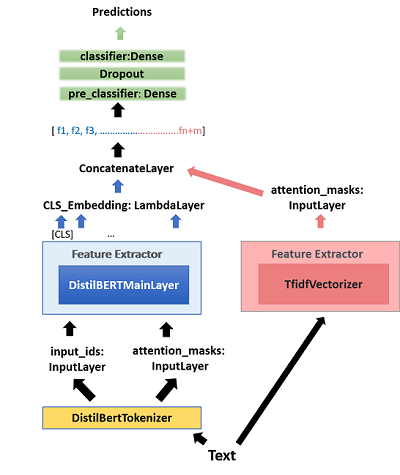

Como puede ver, el modelo consta de:

- un extractor de rasgos basado en Transformers, en particular, una versión pre-entrenada de [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) accesible mediante TFDistilBertMainLayer y [TFDistilBertModel](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel).

- un extractor de rasgos, útil para representar conocimiento específico del dominio. En el ejemplo, utilizando la implementación [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) provista por sklearn.

- un clasificador (red neuronal) que aprenderá a partir de un conjunto de ejemplos donde cada texto se representa a partir de los rasgos obtenidos por los extractores.


**Notar que:**

- en un problema de clasificación multiclases la última capa densa del clasificador debe tener tantas neuronas como posibles categorías contemple el problema. No obstante, en un problema de clasificación binaria, es recomendable tener una sola neurona. Ver *num_labels* en la configuración de DistilBERT.

- el modelo consta de $3$ entradas, dos correspondientes a los id de los tokens y las máscaras que necesita DistilBERT (se obtienen mediante el correspondiente tokenizador) y una entrada correspondiente a los vectores adicionales (se obtiene mediante TfidfVectorizer). 

- la entrada correspondiente al vector de características adicionales (tf-idf) NO es una entrada de TFDistilBertMainLayer, además es conveniente conocer la dimensión de este vector para especificar adecuadamente el shape.


- al tratarse de un modelo Keras, este NO cuenta con funciones *from_pretrained* o *save_pretrained* que nos encontramos en los modelos implementados por Transformers, ej. TFDistilBertForSequenceClassification. Debido a la implementación actual de Transformers, se empleará una solución *ad-hoc* para guardar los pesos del modelo para su posterior uso.

Ejecute las siguientes casillas prestando atención a los comentarios incluidos junto al código.



#### Arquitectura del modelo
En este caso, utilizaremos el API Funcional de Keras para construir el modelo.

**Notar que:**

- debemos cargar la capa que representa al transformer, en este caso, TFDistilBertMainLayer

- dado que la versión actual de Transformers (4.2.1) parece no incluir funcionalidades para cargar los pesos pre-entrenados de TFDistilBertMainLayer, se utiliza la siguiente solución alterna: 
  - (i) cargar algún modelo que contenga esta capa, ej. TFDistilBertModel.
  - (ii) acceder a la capa TFDistilBertMainLayer, que será la que utilizaremos en el modelo. Notar que el nombre de esta capa varía de acuerdo con el modelo base, ej. en TFRobertaModel, la variable que contiene a TFRobertaMainLayer se llama 'roberta'.

- la salida de TFDistilBertMainLayer es un tensor 3D similar al mostrado en la imagen, donde ${}^{l}_{}e^{ti}_{ij}$ se refiere a la dimensión $l$ del embedding correspondiente al token $ti$ de la instancia $j$. En nuestro caso, seguiremos la práctica común de tomar como representación de cada instancia el embedding correspondiente al token CLS.

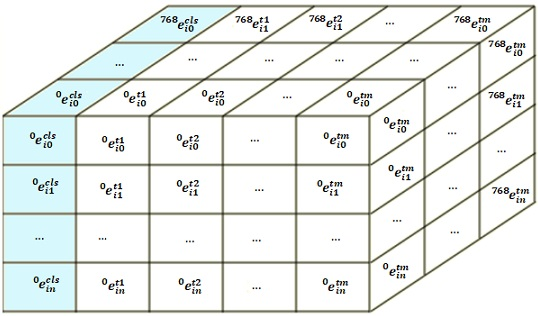

Ejecute la siguiente celda para definir una función que crea la estructura del modelo, devolviendo los elementos que representan las entradas y salidas. Estos se emplearán posteriormente al terminar la configuración del modelo.

In [34]:
def get_model_graph(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = tf.keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = tf.keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32') 

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = tf.keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32') 

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification 
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones 
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = tf.keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)


  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  first_hidden_units = 512
  second_hidden_units = 64
  seq_classif_dropout=0.2
  initializer = tf.keras.initializers.TruncatedNormal(stddev=initializer_range)

  ### Input Transformer

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  first_transformer = tf.keras.layers.Dense(first_hidden_units, kernel_initializer=initializer, activation='relu', name='first_transformer')(transformes_cls_embedding) 

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_transformer = tf.keras.layers.Dropout(rate=seq_classif_dropout, name='dropout_transformer')(first_transformer)  

  second_transformer = tf.keras.layers.Dense(second_hidden_units, kernel_initializer=initializer, activation='relu', name='second_transformer')(dropout_transformer) 

  ### Input TFIDF

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features). first_hidden_units/2
  first_tfidf = tf.keras.layers.Dense(first_hidden_units / 2, kernel_initializer=initializer, activation='relu', name='first_tfidf')(input_tfidf) 

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_tfidf = tf.keras.layers.Dropout(rate=seq_classif_dropout, name='dropout_tfidf')(first_tfidf)  
  # second_hidden_units/2
  second_tfidf = tf.keras.layers.Dense(second_hidden_units / 2, kernel_initializer=initializer, activation='relu', name='second_tfidf')(dropout_tfidf)

  ### Para input pos score, neg score y obj score se añadiran una sola capa densa, ya que el conocimiento se encuentra
  ### más depurado que en los casos anteriores y por ello se ha obtado por una menor profundidad antes de concatenar
  ### los datos con los de las otras entradas
  ### Input pos score

  input_pos_scores = tf.keras.layers.Input(shape=(cfg['max_length'],), name='pos_scores', dtype='int32')

  first_pos_scores = tf.keras.layers.Dense(second_hidden_units, kernel_initializer=initializer, activation='relu', name='first_pos_scores')(input_pos_scores) 

  ### Input neg score
  
  input_neg_scores = tf.keras.layers.Input(shape=(cfg['max_length'],), name='neg_scores', dtype='int32')

  first_neg_scores = tf.keras.layers.Dense(second_hidden_units, kernel_initializer=initializer, activation='relu', name='first_neg_scores')(input_neg_scores) 

  ### Input obj score
  
  input_obj_scores = tf.keras.layers.Input(shape=(cfg['max_length'],), name='obj_scores', dtype='int32')

  first_obj_scores = tf.keras.layers.Dense(second_hidden_units, kernel_initializer=initializer, activation='relu', name='first_obj_scores')(input_obj_scores) 

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features = tf.keras.layers.concatenate([second_transformer, second_tfidf, first_pos_scores, first_neg_scores, first_obj_scores], name='concatenate')

  dropout_features = tf.keras.layers.Dropout(rate=seq_classif_dropout, name='dropout_features')(features)  

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = tf.keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_features)

  return input_ids, input_masks, input_tfidf, input_pos_scores, input_neg_scores, input_obj_scores, classifier

print('Done!')

Done!


#### Configuración del modelo

Una vez instanciadas y conectadas las capas necesarias, es preciso finalizar la configuración del modelo indicando entre otros:
- cuáles serán las entradas y salidas del modelo.
- el algoritmo de optimización a utilizar.
- las métricas a evaluar, etc.

Se sugiere revisar documentación para más detalles sobre los diferentes hiper-parámetros.

Ejecute la siguiente casilla para definir una función que termina de configurar el modelo previo a su entrenamiento.

In [35]:
def configure_model(input_ids, input_masks, input_tfidf, input_pos_scores, input_neg_scores, input_obj_scores, classifier):
  # definir algoritmo de optimización
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  # crear el modelo
  model = tf.keras.Model(inputs=[input_ids, input_masks, input_tfidf, input_pos_scores, input_neg_scores, input_obj_scores,], \
      outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy'])

  return model

print('Done!')

Done!


### Instanciar modelo

En este punto, sólo es necesario instanciar el modelo utilizando las funciones definidas con anterioridad.

In [36]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'#'distilbert-base-uncased-finetuned-sst-2-english'#'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000#11097  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 1  # cambiar este número según el número de clases
cfg['number_of_ngrams'] = 2

print('Done!')

Done!


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                               

c:\Users\OWNER\anaconda3\envs\book\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.



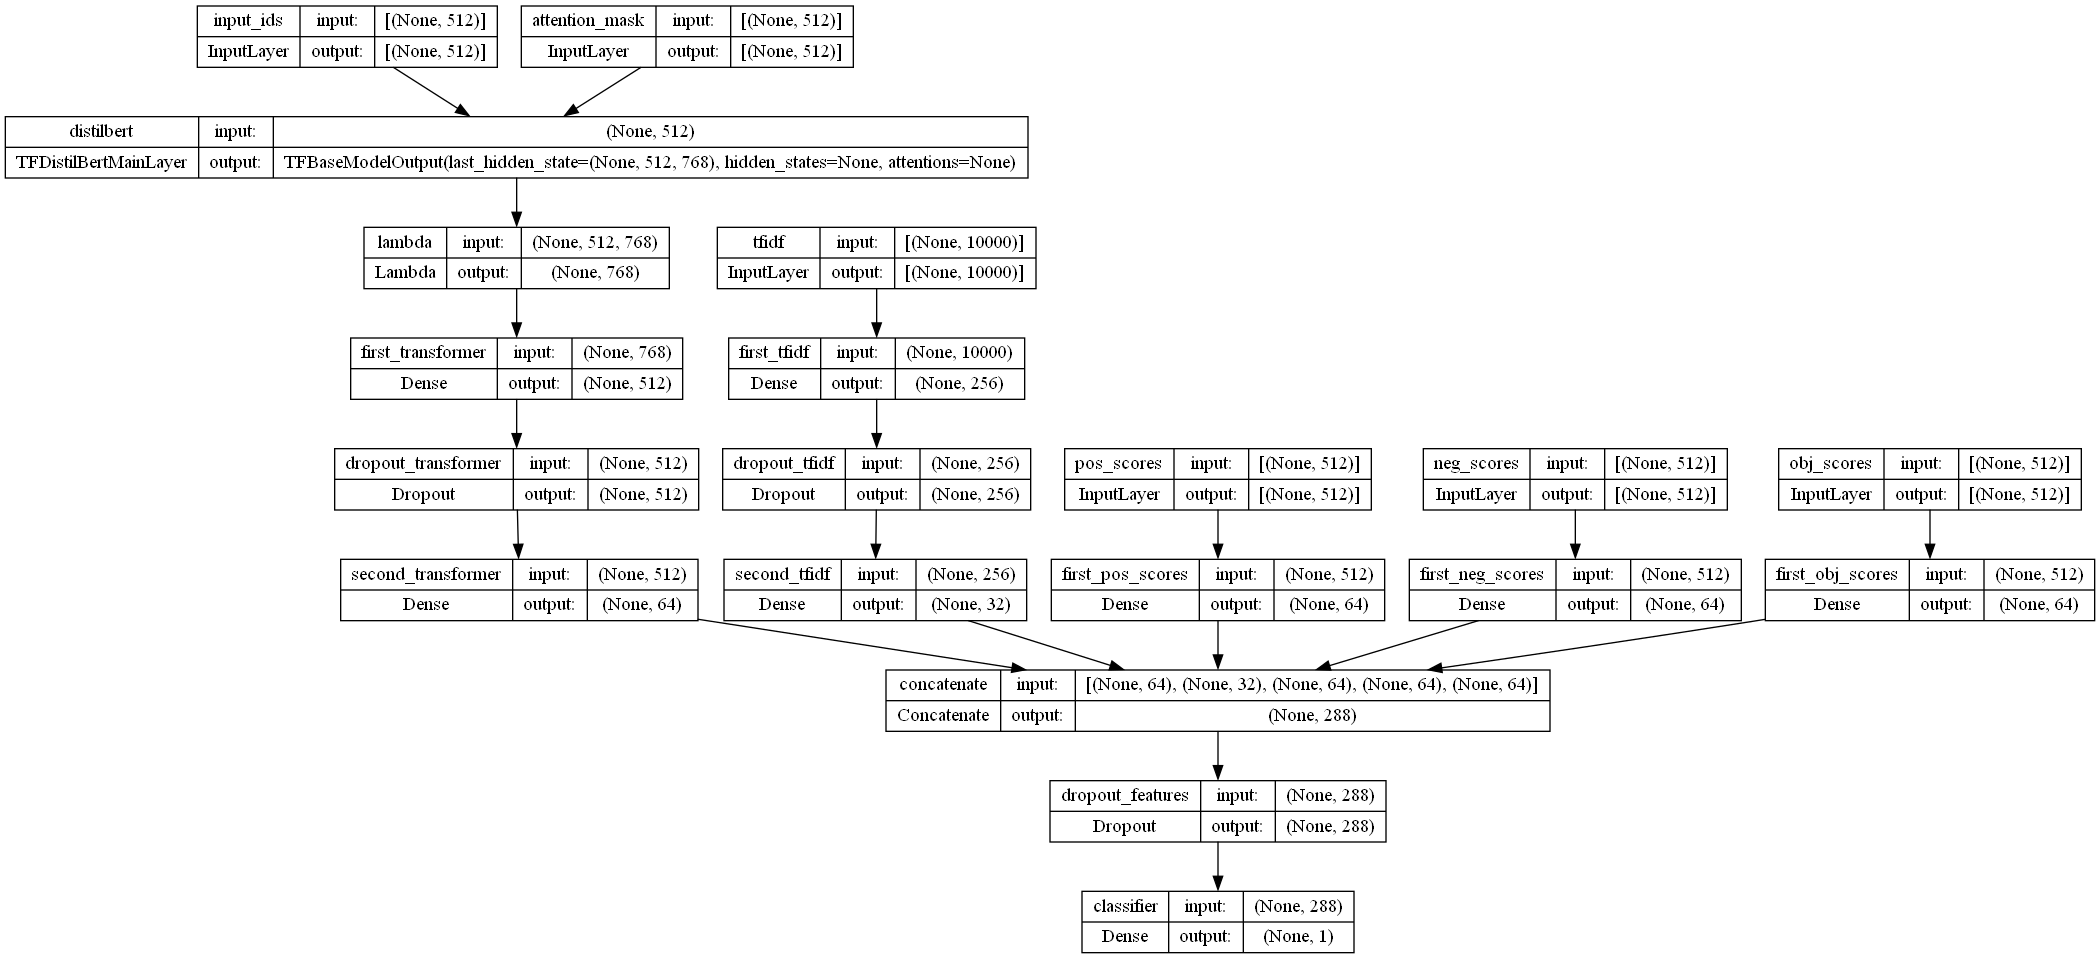

Done!


In [37]:
input_ids, input_masks, input_tfidf, input_pos_scores, input_neg_scores, input_obj_scores, classifier = get_model_graph(cfg)
model = configure_model(input_ids, input_masks, input_tfidf, input_pos_scores, input_neg_scores, input_obj_scores, classifier)


# imprimir sumario del modelo 
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

### Pre-procesamiento de los datos

Antes de entrenar, debemos pre-procesar los datos. Esto dependerá de la tarea en particular, en este caso, comprende:

- tokenizar para obtener los ids y las máscaras. Debe tener en cuenta que el tokenizador debe ser compatible con el modelo a utilizar, DistilBERT en este caso.

- obtener vectores tf-idf correspondientes a cada ejemplo.

- obtener los vectores one-hot correspondientes a las categorías.

- convertir a tensores cuando sea necesario, pues este será el formato de entrada que se utilizará en el modelo. Los tensores representan una estructura multidimensional de Tensorflow para contener los datos.

**Notar que:**
- es necesario codificar el valor correspondiente a la categoría de modo que pueda procesarse por la red neuronal. Podemos asignar valor *1* a la categoría *positive* y *0* a la *negative*.  En un problema de clasificación multiclases, podemos realizar la codificación mediante un vector one-hot. En la actividad utilizaremos [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) de [scikit-learn](https://scikit-learn.org/stable/).

- en dependencia de su implementación del extractor, deberá re-implementar esta sección.

Ejecute las siguientes casilla prestando atención a los comentarios explicativos.


#### Instanciar tokenizador, tf-idf vectorizer, etc.

In [38]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words=STOP_WORDS_SP, max_features=cfg['number_of_additional_features'])

# instanciar TfidfVectorizer
# cfg['n_gramas_vectorizer'] = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(2, 2), max_features=cfg['number_of_ngram_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


#### Pre-procesamiento

In [39]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[TEXT_COL].to_list())
#cfg['n_gramas_vectorizer'].fit(train[TEXT_COL].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# guardar n_gramas entrenado para su posterior uso (codificar nuevos datos).
#with open('n_gramas_vectorizer_reviews.pkl', 'wb') as f:
#    pickle.dump(cfg['n_gramas_vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[CLASS_COL_ST1])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[CLASS_COL_ST1])
val_blabes = cfg['label_binarizer'].transform(val[CLASS_COL_ST1])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs(cfg, train[TEXT_COL].to_list())
val_inputs = get_model_inputs(cfg, val[TEXT_COL].to_list())

print('Done!')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

Done!


### Entrenamiento del modelo

Por último es necesario entrenar el modelo.

**Notar que:**
 - se trata de un modelo Keras, por lo que, para guardarlo y utilizarlo posteriormente, se deberán seguir las recomendaciones para este tipo de objeto (https://www.tensorflow.org/guide/keras/save_and_serialize).
 
 - la ejecución puede tomar un tiempo considerable (horas) o fallar por falta de  memoria en dependencia del hardware y parámetros como el batch_size.

- es recomendable guardar checkpoints del modelo cada epochs_to_save iteraciones.



In [40]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 30
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 8
best_val_acc = 0

# ciclo de entrenamiento y guardar checkpoints
for epoch in tqdm(range(0, epochs_max, epochs_to_save)):
    print('Training model, epochs {0} - {1}'.format(epoch+1, epochs_max))
    
    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, epochs=epochs_to_save, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))
    
    ### Obtenemos la binary_accuracy de la validación. De esta manera podremos utilizar
    ### la accuracy de la validación para determinar si guardar el modelo
    val_acc = model.history.history['val_binary_accuracy'][0]
    
    if val_acc > best_val_acc:
        model.save_weights(cfg['trained_model_name'], save_format="tf")
        best_val_acc = val_acc
        print(f"\nNew best model with {best_val_acc} val accuracy!\n")
    
print('Done!')

  0%|          | 0/30 [00:00<?, ?it/s]

Training model, epochs 1 - 30
379/379 [==============================] - 164s 413ms/step - loss: 0.6577 - binary_accuracy: 0.5626 - val_loss: 0.6514 - val_binary_accuracy: 0.6499


  3%|▎         | 1/30 [02:46<1:20:19, 166.20s/it]


New best model with 0.6498516201972961 val accuracy!

Training model, epochs 2 - 30
379/379 [==============================] - 157s 415ms/step - loss: 0.6307 - binary_accuracy: 0.6374 - val_loss: 0.6488 - val_binary_accuracy: 0.6469


  7%|▋         | 2/30 [05:23<1:15:07, 160.98s/it]

Training model, epochs 3 - 30
379/379 [==============================] - 157s 413ms/step - loss: 0.6617 - binary_accuracy: 0.5765 - val_loss: 0.6647 - val_binary_accuracy: 0.5341


 10%|█         | 3/30 [08:00<1:11:34, 159.05s/it]

Training model, epochs 4 - 30
379/379 [==============================] - 157s 416ms/step - loss: 0.6320 - binary_accuracy: 0.5345 - val_loss: 0.6038 - val_binary_accuracy: 0.5430


 13%|█▎        | 4/30 [10:37<1:08:40, 158.47s/it]

Training model, epochs 5 - 30
379/379 [==============================] - 4621s 12s/step - loss: 0.5348 - binary_accuracy: 0.6192 - val_loss: 0.5365 - val_binary_accuracy: 0.7211


 17%|█▋        | 5/30 [1:27:41<12:16:59, 1768.77s/it]


New best model with 0.721068263053894 val accuracy!

Training model, epochs 6 - 30
379/379 [==============================] - 147s 388ms/step - loss: 0.4466 - binary_accuracy: 0.7749 - val_loss: 0.5006 - val_binary_accuracy: 0.7240


 20%|██        | 6/30 [1:30:11<8:07:19, 1218.33s/it] 


New best model with 0.7240356206893921 val accuracy!

Training model, epochs 7 - 30
379/379 [==============================] - 149s 392ms/step - loss: 0.3799 - binary_accuracy: 0.8221 - val_loss: 0.4892 - val_binary_accuracy: 0.7389


 23%|██▎       | 7/30 [1:32:42<5:33:16, 869.41s/it] 


New best model with 0.7388724088668823 val accuracy!

Training model, epochs 8 - 30
379/379 [==============================] - 150s 395ms/step - loss: 0.3326 - binary_accuracy: 0.8469 - val_loss: 0.4867 - val_binary_accuracy: 0.7300


 27%|██▋       | 8/30 [1:35:12<3:54:47, 640.35s/it]

Training model, epochs 9 - 30
379/379 [==============================] - 150s 395ms/step - loss: 0.2931 - binary_accuracy: 0.8727 - val_loss: 0.4910 - val_binary_accuracy: 0.7389


 30%|███       | 9/30 [1:37:42<2:50:26, 486.98s/it]

Training model, epochs 10 - 30
179/379 [=============>................] - ETA: 1:16 - loss: 0.2659 - binary_accuracy: 0.8904

 30%|███       | 9/30 [1:38:51<3:50:39, 659.01s/it]


KeyboardInterrupt: 

### Evaluación del modelo
Luego de entrenado el modelo, podemos evaluar su desempeño en los conjuntos de entrenamiento y validación.

Ejecute la siguiente casilla para evaluar el modelo en el conjunto de entrenamiento.

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[CLASS_COL_ST1]

m_pred = predict_model(model, cfg, data[TEXT_COL].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

95/95 [==============================] - 47s 479ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1618
           1       0.98      0.98      0.98      1407

    accuracy                           0.98      3025
   macro avg       0.98      0.98      0.98      3025
weighted avg       0.98      0.98      0.98      3025

Accuracy -> 98.02%



Done!


Ejecute la siguiente casilla para evaluar el modelo en el conjunto de validación. Compare los resultados.

In [ ]:
# predecir los datos de validación
data = val
true_labels = data[CLASS_COL_ST1]

m_pred = predict_model(model, cfg, data[TEXT_COL].to_list(), pref='m')

evaluate_model(true_labels, m_pred['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

11/11 [==============================] - 5s 460ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       180
           1       0.71      0.64      0.67       157

    accuracy                           0.71       337
   macro avg       0.71      0.70      0.71       337
weighted avg       0.71      0.71      0.71       337

Accuracy -> 70.92%



Done!


## Predicción de nuevos datos

Una vez entrenado el modelo, podemos evaluar su rendimiento en datos no utilizados durante el aprendizaje o emplearlo para predecir nuevas instancias. En cualquier caso, se debe cuidar realizar los pasos de pre-procesamiento necesarios según el caso. En el ejemplo, utilizaremos la porción de prueba preparada inicialmente.

**Notar que**:
-  se cargará el modelo previamente entrenado, estableciendo las configuraciones pertinentes.

- se debe decodificar la salida del modelo para obtener la correspondiente categoría utilizando el mismo codificador.

- si disponemos de un modelo guardado, podremos ejecutar directamente esta parte del cuaderno. Sin embargo, será necesario al menos ejecutar previamente las secciónes [Instalación de librerías...](#sec:setup) e [Implementación y configuración del modelo](#sec:config_model).

### Cargar otros elementos necesarios 

Antes de predecir nuevos datos, también es preciso cargar otros elementos necesarios como el tokenizador, el codificador para las etiquetas, etc.

Ejecute la siguiente casilla.

In [ ]:
# configuraciones
#text_col = 'Phrase'  # columna del dataframe que contiene el texto (depende del formato de los datos)
#class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 1  # ver descripción de la sección "Implementación y configuración del modelo"

cfg['checkpoints_dir'] = 'checkpoints'
cfg['model_name'] = 'distilbert-reviews'
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

# cargar tokenizador
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'])

# cargar el codificador one-hot utilizado para codificar las categorías en los datos de entrenamiento
# es necesario para realizar la transformación inversa de la salida de la red y conocer el número de categorías
with open('label_binarizer_reviews.pkl', 'rb') as f:
    cfg['label_binarizer'] = pickle.load(f)


# cargar TfidfVectorizer
with open('vectorizer_reviews.pkl', 'rb') as f:
    cfg['vectorizer'] = pickle.load(f)

print('Done!')

Done!


### Instanciar modelo pre-entrenado

Para predecir nuevas instancias es preciso cargar el modelo previamente entrenado. Esto dependerá del formato en el que se exportó el modelo, pero en general se requieren dos elementos: la estructura del modelo y los pesos. En este caso, sólo se han guardado los pesos, por lo que se deberá reconstruir manualmente la estructura del modelo.

Ejecute la siguiente casilla para construir el modelo y cargar los pesos. Para detalles sobre la estructura del modelo puede ver la sección [Implementación y configuración del modelo](#sec:config_model).

In [ ]:
input_ids, input_masks, input_tfidf, classifier = get_model_graph(cfg)
model = configure_model(input_ids, input_masks, input_tfidf, classifier)

# cargar pesos del modelo
model.load_weights(cfg['trained_model_name'])

print('Done!')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
c:\Users\OWNER\anaconda3\envs\book\lib\site-packages\keras\initializers\

ValueError: too many values to unpack (expected 4)

### Predecir nuevos datos

Con el modelo y el tokenizador cargados, es posible utilizarlo para analizar nuevos datos. 

Ejecute las siguientes casillas para:

(a) categorizar un texto de muestra.

(b) cargar nuevos datos, categorizarlos y mostrar algunas estadísticas sobre el corpus.

In [ ]:
# ejemplo de texto a clasificar, # lista [texto 1, text 2, ..., texto n]
text = ['Brian De Palma\'s undeniable virtuosity can\'t really camouflage the fact that his plot here is a thinly disguised\
        \"Psycho\" carbon copy, but he does provide a genuinely terrifying climax. His "Blow Out", made the next year, was an improvement.']

m_pred = predict_model(model, cfg, text, pref='m')

pred_labels = m_pred['labels_m'].values[0]
pred_proba = m_pred['scores_m'].values[0]

print(f'La categoría de la frase es -> {pred_labels}')
print(f'El score asignado a la clase positiva es -> {pred_proba:.2f}')

print('Done!')


También podemos predecir nuevos datos cargados desde un fichero. 

Ejecute la siguiente casilla, descomentando las instrucciones necesarias según sea el caso.

In [ ]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/04-SA-Transformers-Training-Custom/sample_data/ejemplo_review_train.csv'

# leer los datos
new_data = pd.read_csv(path, sep=',')

print('Done!')

Ejecute la siguiente celda para predecir los datos y mostrar algunas estadísticas sobre el análisis realizado.

In [ ]:
# predecir los datos de prueba
m_pred = predict_model(model, cfg, new_data[text_col].to_list(), pref='m')
pred_labels = m_pred['labels_m']

# obtener algunas estadísticas sobre la predicción en el conjunto de pruebas
categories = sorted(pred_labels.unique(), reverse=False)
hist = Counter(pred_labels.values) 

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ejemplos de texto
text_data = ["Este es un ejemplo de texto.",
             "Este es otro ejemplo de texto.",
             "Este es un ejemplo más de texto."]

# Creación de un objeto CountVectorizer para extraer los n-gramas
vectorizer = CountVectorizer(ngram_range=(1, 2))

# Ajustar el objeto CountVectorizer a los datos de texto
vectorizer.fit(text_data)

# Transformar los datos de texto a una matriz de características
features = vectorizer.transform(text_data)

# Ver las características extraídas
print(vectorizer.get_feature_names_out())
print(features.toarray())